In [ ]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Positive_tensors.zip
!unzip -q Negative_tensors.zip

In [ ]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split, ConcatDataset
from torchvision import transforms
import numpy as np
import torchvision.models as models
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random


def show_data(data_sample, shape=(200, 200)):
    image = data_sample[0].permute(1, 2, 0).numpy()
    image_min, image_max = image.min(), image.max()
    image = (image - image_min) / (image_max - image_min)
    plt.imshow(image, vmin=0, vmax=1)
    plt.title(f'y = {data_sample[1]}')
    plt.show()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class Data(Dataset):
  def __init__(self, train=True, transform=None):
    dir = '/content/'
    pos = 'Positive_tensors'
    neg = 'Negative_tensors'
    pos_path = os.path.join(dir, pos)
    neg_path = os.path.join(dir, neg)
    pos_files = [os.path.join(pos_path, i) for i in os.listdir(pos_path) if i.endswith(".pt")]
    neg_files = [os.path.join(neg_path, i) for i in os.listdir(neg_path) if i.endswith(".pt")]
    number_of_data = len(pos_files) + len(neg_files)
    self.all_files = number_of_data*[None]
    self.all_files[::2] = pos_files
    self.all_files[1::2] = neg_files
    self.transform = transform
    self.Y=torch.zeros([number_of_data]).type(torch.LongTensor)
    self.Y[::2]=1
    self.Y[1::2]=0

    if train:
      self.all_files=self.all_files[0:30000]
      self.Y=self.Y[0:30000]
      self.len=len(self.all_files)
    else:
      self.all_files=self.all_files[30000:]
      self.Y=self.Y[30000:]
      self.len=len(self.all_files)

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    image=torch.load(self.all_files[idx])
    y=self.Y[idx]
    if self.transform:
      image = self.transform(image)
    return image, y

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128))
])
train_set = Data(train = True, transform = transform)
validation_set = Data(train = False, transform = transform)
train_loader = DataLoader(train_set, batch_size = 32, pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size = 32)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


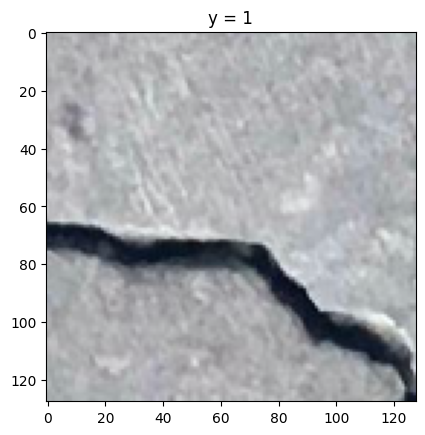

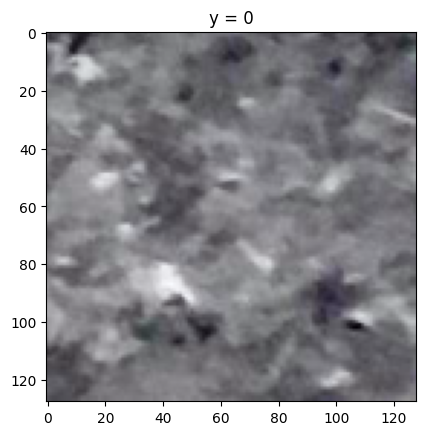

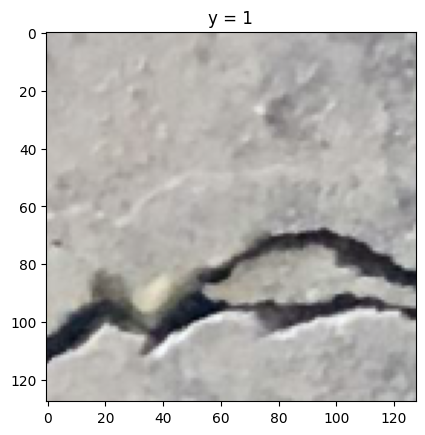

In [ ]:
for i in range(3):
  show_data(train_set[i])
plt.show()

In [ ]:
class Resnet50(nn.Module):
    def __init__(self, num_classes):
        super(Resnet50, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.num_features = self.resnet.fc.out_features
        self.classifier = nn.Linear(self.num_features, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        return x

In [ ]:
model = Resnet50(2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 101MB/s]


In [ ]:
epochs = 10
def train_model(model, train_loader, validation_loader, optimizer, criterion, epochs):
    train_loss_list = []
    validation_loss_list = []
    train_accuracy_list = []
    validation_accuracy_list =  []
    N_train = len(train_loader.dataset)
    N_validation = len(validation_loader.dataset)

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        epoch_train_correct = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yhat_train = model(x)
            loss = criterion(yhat_train, y)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            _, yhat_max = torch.max(yhat_train, 1)
            epoch_train_correct += (yhat_max == y).sum().item()

        # Validation phase
        model.eval()
        epoch_validation_loss = 0.0
        epoch_validation_correct = 0
        with torch.no_grad():
            for x_cv, y_cv in validation_loader:
                x_cv, y_cv = x_cv.to(device), y_cv.to(device)
                yhat_validation = model(x_cv)
                loss = criterion(yhat_validation, y_cv)
                epoch_validation_loss += loss.item()
                _, yhat_max = torch.max(yhat_validation, 1)
                epoch_validation_correct += (yhat_max == y_cv).sum().item()


        train_loss = epoch_train_loss / N_train
        train_accuracy = epoch_train_correct / N_train
        validation_loss = epoch_validation_loss / N_validation
        validation_accuracy = epoch_validation_correct / N_validation

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        validation_loss_list.append(validation_loss)
        validation_accuracy_list.append(validation_accuracy)

        print(f'Epoch: {epoch} ------ Train Loss: {train_loss} ------ Validation Loss: {validation_loss} ------ Train Accuracy: {train_accuracy} ------ Validation Accuracy: {validation_accuracy}')
    fig, axs = plt.subplots(1, 2, figsize=(12, 8))
    axs[0].plot(train_loss_list, label='Train Loss')
    axs[0].plot(validation_loss_list, label='Validation Loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(train_accuracy_list, label='Train Accuracy')
    axs[1].plot(validation_accuracy_list, label='Validation Accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

Epoch: 0 ------ Train Loss: 0.0013507990248283021 ------ Validation Loss: 0.0011055867482435134 ------ Train Accuracy: 0.9852333333333333 ------ Validation Accuracy: 0.9888
Epoch: 1 ------ Train Loss: 0.0008489125542848039 ------ Validation Loss: 0.0011496328417955738 ------ Train Accuracy: 0.9915666666666667 ------ Validation Accuracy: 0.9887
Epoch: 2 ------ Train Loss: 0.0007792869240673553 ------ Validation Loss: 0.0011566882475789043 ------ Train Accuracy: 0.9924666666666667 ------ Validation Accuracy: 0.9895
Epoch: 3 ------ Train Loss: 0.0007574863884496229 ------ Validation Loss: 0.0012224073316208887 ------ Train Accuracy: 0.9931 ------ Validation Accuracy: 0.9887
Epoch: 4 ------ Train Loss: 0.0007495447238793114 ------ Validation Loss: 0.0012147536297767146 ------ Train Accuracy: 0.9934666666666667 ------ Validation Accuracy: 0.9892
Epoch: 5 ------ Train Loss: 0.0007126941254773224 ------ Validation Loss: 0.0012705217970040736 ------ Train Accuracy: 0.9935666666666667 ------ Va

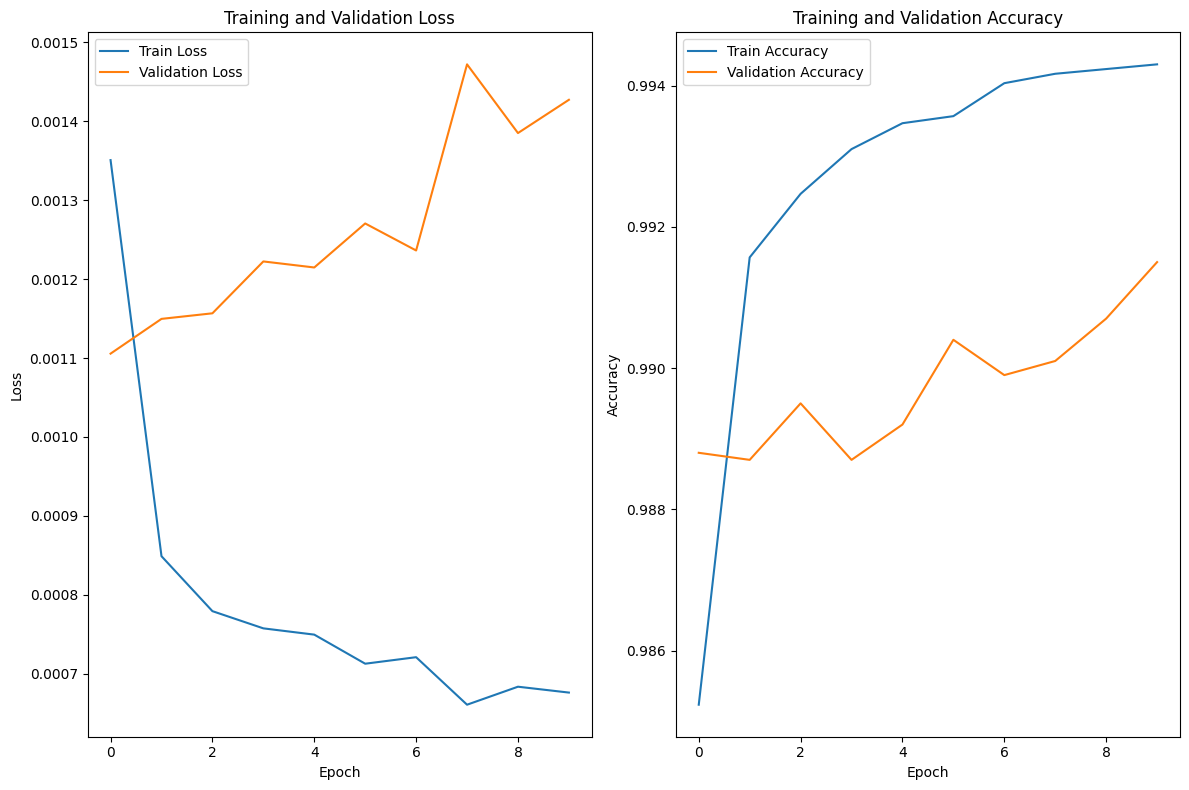

In [ ]:
train_model(model, train_loader, validation_loader, optimizer, criterion, epochs)

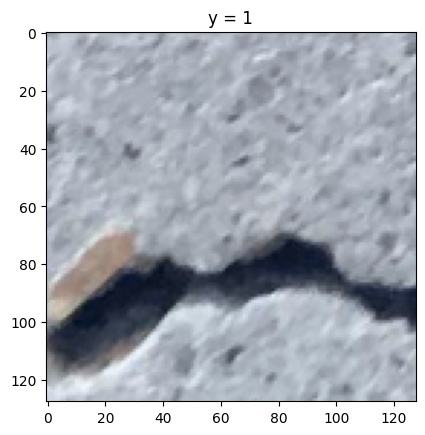

probability of class  0.8358487486839294


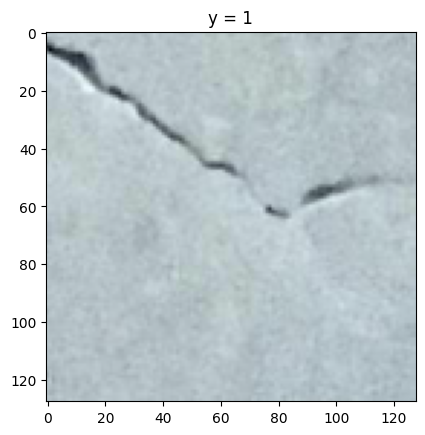

probability of class  0.9513382911682129


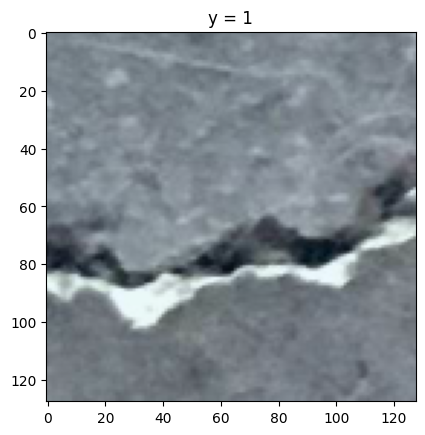

probability of class  0.9519685506820679


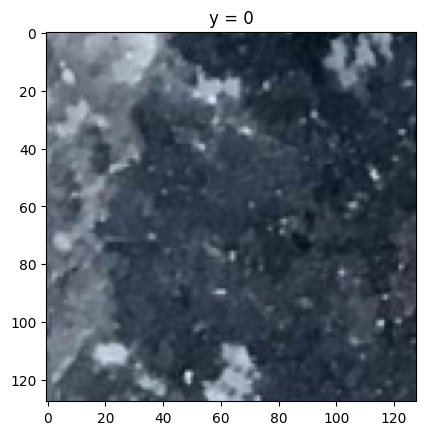

probability of class  0.9276328682899475


In [ ]:
Softmax_fn = nn.Softmax(dim=-1)
count = 0
model.to('cpu')
for x, y in validation_set:
    x = x.unsqueeze(0)
    z = model(x)
    _, yhat = torch.max(z, 1)
    if yhat != y:
      show_data((x.squeeze(), y))
      plt.show()
      print("probability of class ", torch.max(Softmax_fn(z)).item())
      count += 1
    if count >= 4:
        break